In [74]:
import tensorflow as tf
from tensorflow.keras import layers
import os
import glob
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt


In [75]:
def load_images(image_paths, image_size=(128, 128)):
    images = []
    for image_path in image_paths:
        image = Image.open(image_path).resize(image_size)
        image = np.array(image)
        images.append(image)
    images = np.array(images)
    images = (images - 127.5) / 127.5  
    plt.imshow(images[np.random.randint(0, 289)])
    plt.axis('off')  
    plt.show()
    return images

In [76]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(256, input_shape=(100,)))
    model.add(layers.LeakyReLU())
    model.add(layers.BatchNormalization())
    
    model.add(layers.Dense(512))
    model.add(layers.LeakyReLU())
    model.add(layers.BatchNormalization())
    
    model.add(layers.Dense(1024))
    model.add(layers.LeakyReLU())
    model.add(layers.BatchNormalization())
    
    model.add(layers.Dense(128 * 128 * 3, activation='tanh'))
    model.add(layers.Reshape((128, 128, 3)))  
    return model


In [77]:
def make_discriminator_model(image_size):
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=(128, 128, 3)))  
    model.add(layers.Flatten())
    
    model.add(layers.Dense(256))  
    model.add(layers.LeakyReLU())
    
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

In [79]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [80]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

In [82]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [83]:
image_paths = glob.glob('/kaggle/input/data67/*.png')  
image_size = (128, 128)   
batch_size = 16
z_dim = 100

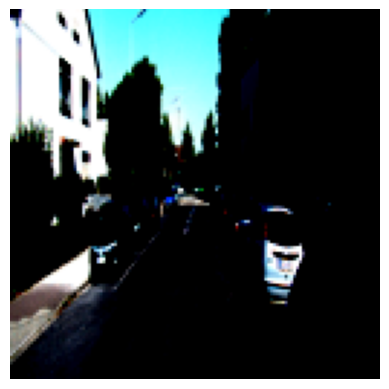

289

In [84]:
training_data = load_images(image_paths, image_size)
len(training_data)

In [85]:
train_dataset = tf.data.Dataset.from_tensor_slices(training_data).shuffle(len(training_data)).batch(batch_size)

In [86]:
generator = make_generator_model()

In [87]:
discriminator = make_discriminator_model(image_size)

In [88]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [90]:
def train_step(images):
    noise = tf.random.normal([batch_size, z_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        
      #  generated_images = tf.image.resize(generated_images, (128, 128))
        
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


In [91]:
def train(dataset, epochs):
    for epoch in range(epochs):
        print("Current Epoch : ", epoch)
        for image_batch in dataset:
            train_step(image_batch)
           

In [92]:
model = train(train_dataset, epochs=50)

Current Epoch :  0
Current Epoch :  1
Current Epoch :  2
Current Epoch :  3
Current Epoch :  4
Current Epoch :  5
Current Epoch :  6
Current Epoch :  7
Current Epoch :  8
Current Epoch :  9
Current Epoch :  10
Current Epoch :  11
Current Epoch :  12
Current Epoch :  13
Current Epoch :  14
Current Epoch :  15
Current Epoch :  16
Current Epoch :  17
Current Epoch :  18
Current Epoch :  19
Current Epoch :  20
Current Epoch :  21
Current Epoch :  22
Current Epoch :  23
Current Epoch :  24
Current Epoch :  25
Current Epoch :  26
Current Epoch :  27
Current Epoch :  28
Current Epoch :  29
Current Epoch :  30
Current Epoch :  31
Current Epoch :  32
Current Epoch :  33
Current Epoch :  34
Current Epoch :  35
Current Epoch :  36
Current Epoch :  37
Current Epoch :  38
Current Epoch :  39
Current Epoch :  40
Current Epoch :  41
Current Epoch :  42
Current Epoch :  43
Current Epoch :  44
Current Epoch :  45
Current Epoch :  46
Current Epoch :  47
Current Epoch :  48
Current Epoch :  49


In [93]:
model.save('/kaggle/working/model.h5')

AttributeError: 'NoneType' object has no attribute 'save'

In [ ]:
def generate_and_save_images(model, test_input, num_examples_to_generate=16):
    # Ensure the training parameter is set to False because we are not training the model during inference.
    predictions = model(test_input, training=False)
    
    # Create a figure with a grid of subplots
    fig = plt.figure(figsize=(4,4))
    
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow((predictions[i, :, :, :] + 1) / 2)  # Rescale the image pixels to [0, 1]
        plt.axis('off')
    
    plt.show()  # Display the figure with the generated images

In [94]:
def generate_and_save_images_individual(model, test_input, num_examples_to_generate=16, save_dir='/kaggle/working'):
    predictions = model(test_input, training=False)
    
     # Create a figure with a grid of subplots
    fig = plt.figure(figsize=(4,4))
    
    for i in range(predictions.shape[0]):
        # Normalize the pixel values to [0, 255]
        img = np.clip((predictions[i, :, :, :] + 1) * 127.5, 0, 255).astype(np.uint8)
        
        # Convert to PIL Image to save
        img = Image.fromarray(img)
        
        # Save each image
        img.save(f'{save_dir}/image_{i+1}.png')
        
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow((predictions[i, :, :, :] + 1) / 2)  # Rescale the image pixels to [0, 1]
        plt.axis('off')
    
    plt.show() 
    
    

In [95]:
random_vector_for_generation = tf.random.normal([16, z_dim])

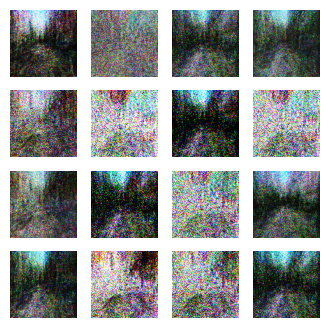

In [96]:
generate_and_save_images_individual(generator, random_vector_for_generation)

In [ ]:
import cv2

# Load the noisy image
image_path = '/kaggle/working/image_14.png'  # Replace with
noisy_image = cv2.imread(image_path)

if noisy_image is not None:
    # Apply Non-Local Means Denoising
    denoised_image = cv2.fastNlMeansDenoisingColored(noisy_image, None, 10, 10, 7, 21)

    # Save the denoised image
    denoised_image_path = '/kaggle/working/denoised_image.png'
    cv2.imwrite(denoised_image_path, denoised_image)
    print(f"Denoised image saved to: {denoised_image_path}")
else:
    print(f"Failed to load image from {image_path}")